# iEEG Data

Analyze iEEG data. 

## Dataset Details

This notebook analyzes data from the openly available MNI dataset.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from mne.io import read_raw_edf

from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files
from apm.run import run_measures
from apm.analysis import compute_all_corrs, compute_corrs_to_feature, compute_diffs_to_feature
from apm.plts import plot_dots
from apm.plts.utils import make_axes
from apm.plts.settings import EXT
from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
                         lempelziv, app_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
                                  HJC_PARAMS, LZ_PARAMS, AP_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/plts/data.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [3]:
#import seaborn as sns
#sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = Path('/Users/tom/Data/External/iEEG/MNI/Wakefulness_AllRegions/')

In [5]:
# Define data information
fs = 200

In [6]:
# Settings for saving figures
SAVE_FIG = False
FIGPATH = APMDB().figs_path / '53_ieeg_data'

## Load Data

Notes:
- time range issue: values beyond 60s

In [7]:
# Get the list of available files
files = get_files(folder)

In [8]:
# Check the number of files
n_files = len(files)
print('Number of files: {}'.format(n_files))

Number of files: 38


In [43]:
# Set an example file to load
file = files[27]
file

'Precentral gyrus_W.edf'

In [44]:
# Load data file
edf = read_raw_edf(folder / file, verbose=False)

In [75]:
# Extract times series from data object
times = edf.times
data = np.array(edf.get_data())

In [46]:
# Restrict data to times of interest
mask = times < 60
data = data[:, mask]
times = times[mask]

In [47]:
# Check data shape
n_chs, n_times = data.shape
n_chs, n_times

(123, 12000)

In [48]:
# Load all data files
all_data = []
for file in files:
    
    edf = read_raw_edf(folder / file, verbose=False)
    
    data = edf.get_data()
    data = data[:, edf.times < 60]
    
    all_data.append(data)
    
all_data = np.vstack(all_data)

In [49]:
# Check the number of channels
n_chans = all_data.shape[0]
print('Number of channels: {}'.format(n_chans))

Number of channels: 1772


## Data Checks

In [55]:
ind = 1

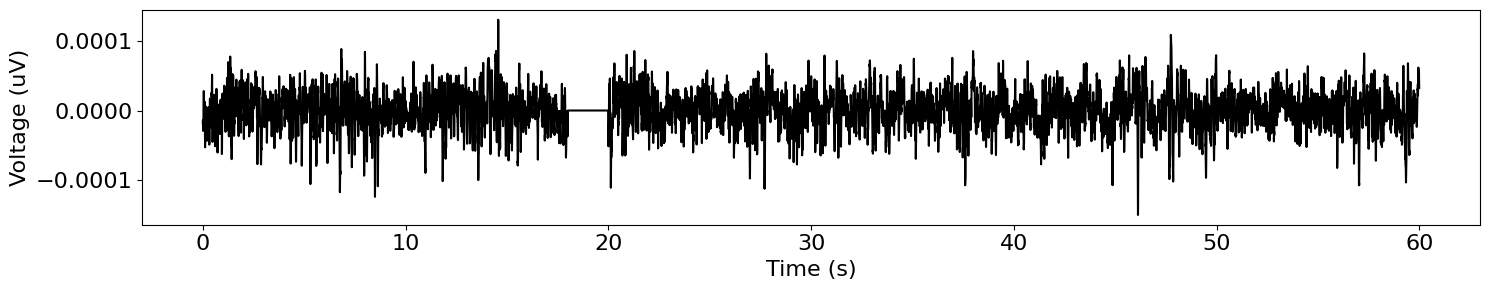

In [56]:
# Plot an example time series (full time)
plot_time_series(times, data[ind, :])

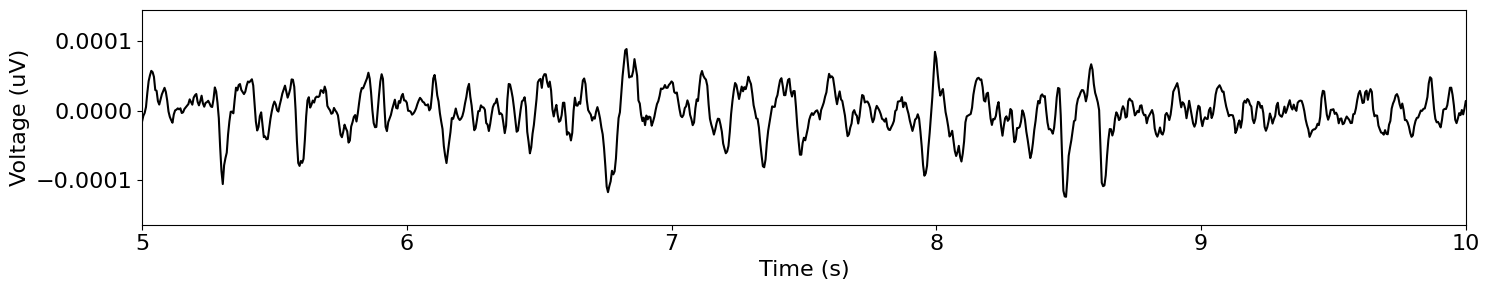

In [57]:
# Plot a zoomed in segment of a time series
plot_time_series(times, data[ind, :], xlim=[5, 10])

In [58]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

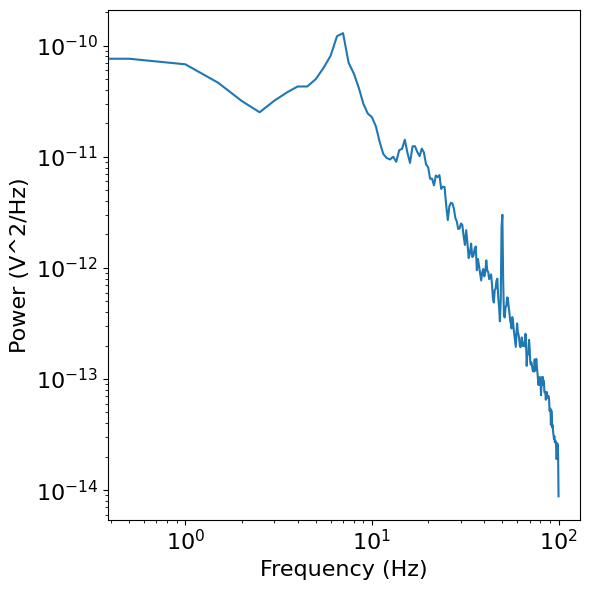

In [59]:
plot_power_spectra(freqs, powers)

## Compare Methods

In [60]:
# Settings for spectral parameterization
f_range = [3, 75]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : fs, 'f_range' : f_range}
irasa_kwargs = {'fs' : fs, 'f_range' : f_range}

In [61]:
# Define measures to apply
measures = {
    autocorr_decay_time : AC_DECAY_PARAMS,
    hurst : HURST_PARAMS,
    dfa : DFA_PARAMS,
    higuchi_fd : HFD_PARAMS,
    hjorth_complexity : HJC_PARAMS,
    lempelziv : LZ_PARAMS,
    app_entropy : AP_ENT_PARAMS,
    perm_entropy : PE_ENT_PARAMS,
    specparam : specparam_kwargs,
    irasa : irasa_kwargs,
}

In [76]:
# Compute measures of interest on the data
results = run_measures(data, measures)

In [77]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

#### Compare exponent measures

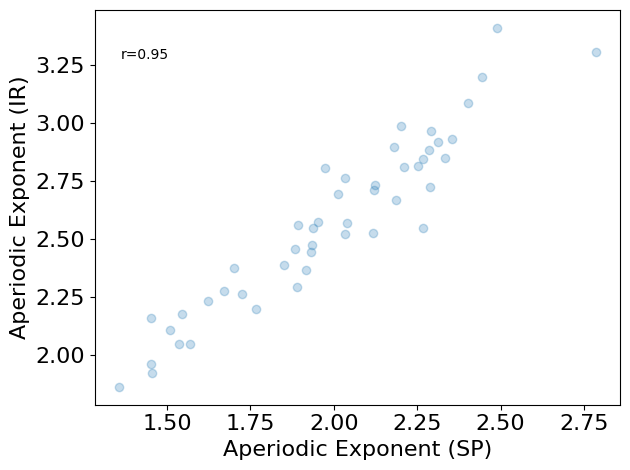

In [78]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam'], results['irasa'], alpha=0.25, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='ieeg_exp_exp' + EXT, file_path=FIGPATH)

In [79]:
# Check correlation between exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.945  CI[+0.873, +0.975],  p=0.000


#### Compare exponent to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


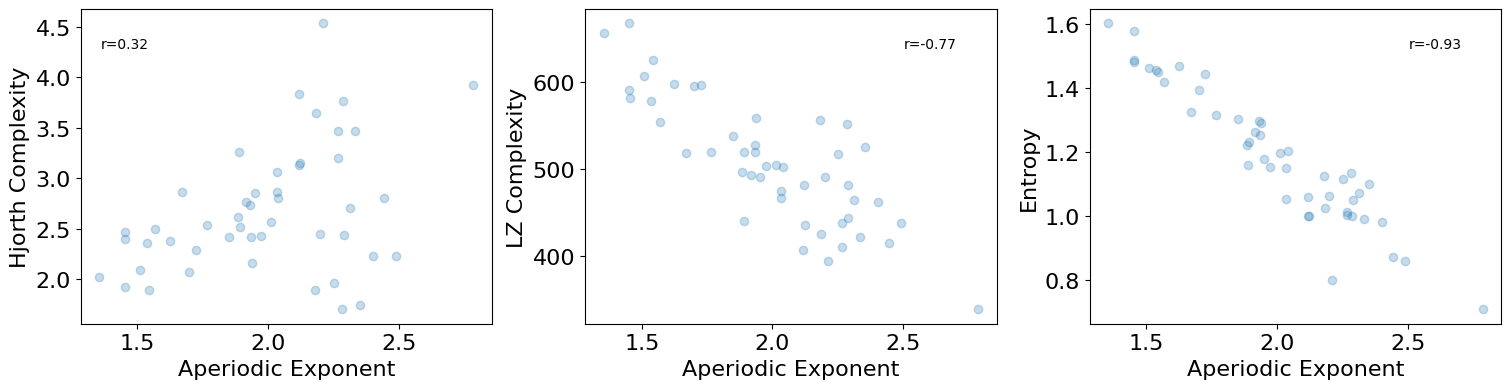

In [80]:
# Comparisons of aperiodic exponent to other measures
axes = make_axes(1, 3, figsize=(15, 4), wspace=0.4)
plot_dots(results['specparam'], results['hjorth_complexity'], alpha=0.25, tposition='tl',
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[0])
plot_dots(results['specparam'], results['lempelziv'], alpha=0.25,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[1])
plot_dots(results['specparam'], results['app_entropy'], alpha=0.25,
          xlabel='Aperiodic Exponent', ylabel='Entropy', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_exp_other' + EXT))

In [81]:
# Check correlation between measures and exponent
print('  SP-EXP & HJC:  ', format_corr(*all_corrs['specparam']['hjorth_complexity']))
print('  SP-EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  SP-EXP & ENT:  ', format_corr(*all_corrs['specparam']['app_entropy']))

  SP-EXP & HJC:   r=+0.322  CI[+0.010, +0.623],  p=0.027
  SP-EXP & LZC:   r=-0.768  CI[-0.883, -0.577],  p=0.000
  SP-EXP & ENT:   r=-0.933  CI[-0.971, -0.844],  p=0.000


#### Compare entropy to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


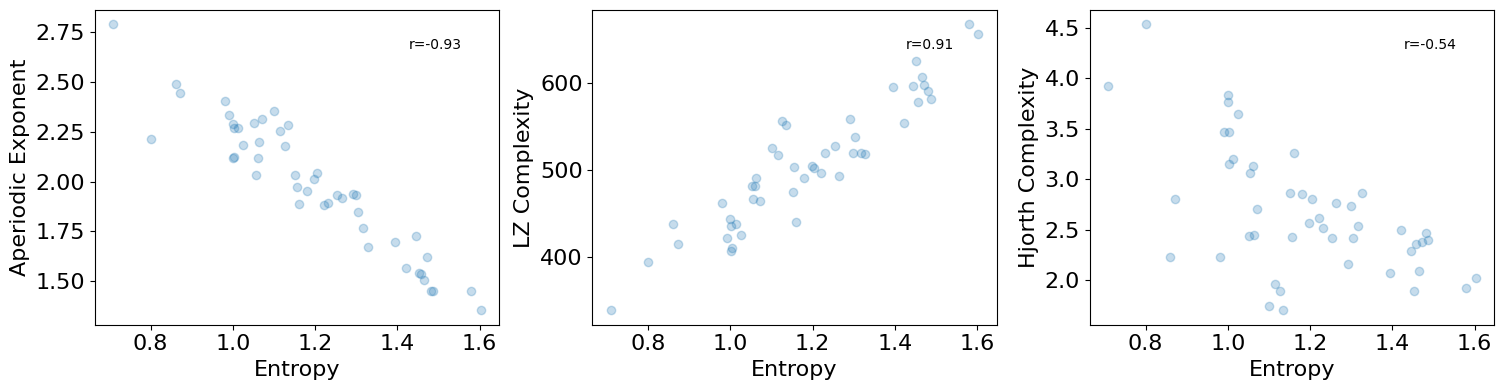

In [82]:
# Comparisons of entropy to other measures
axes = make_axes(1, 3, figsize=(15, 4), wspace=0.4)
plot_dots(results['app_entropy'], results['specparam'], alpha=0.25,
          xlabel='Entropy', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(results['app_entropy'], results['lempelziv'], alpha=0.25,
          xlabel='Entropy', ylabel='LZ Complexity', ax=axes[1])
plot_dots(results['app_entropy'], results['hjorth_complexity'], alpha=0.25,
          xlabel='Entropy', ylabel='Hjorth Complexity', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_info_other' + EXT))

In [83]:
# Check correlation between entropy and other measures
print('  ENT & EXP:  ', format_corr(*all_corrs['app_entropy']['specparam']))
print('  ENT & HJC:  ', format_corr(*all_corrs['app_entropy']['hjorth_complexity']))
print('  ENT & LZC:  ', format_corr(*all_corrs['app_entropy']['lempelziv']))

  ENT & EXP:   r=-0.933  CI[-0.971, -0.844],  p=0.000
  ENT & HJC:   r=-0.538  CI[-0.754, -0.268],  p=0.000
  ENT & LZC:   r=+0.907  CI[+0.808, +0.951],  p=0.000


#### Compare LZ complexity to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


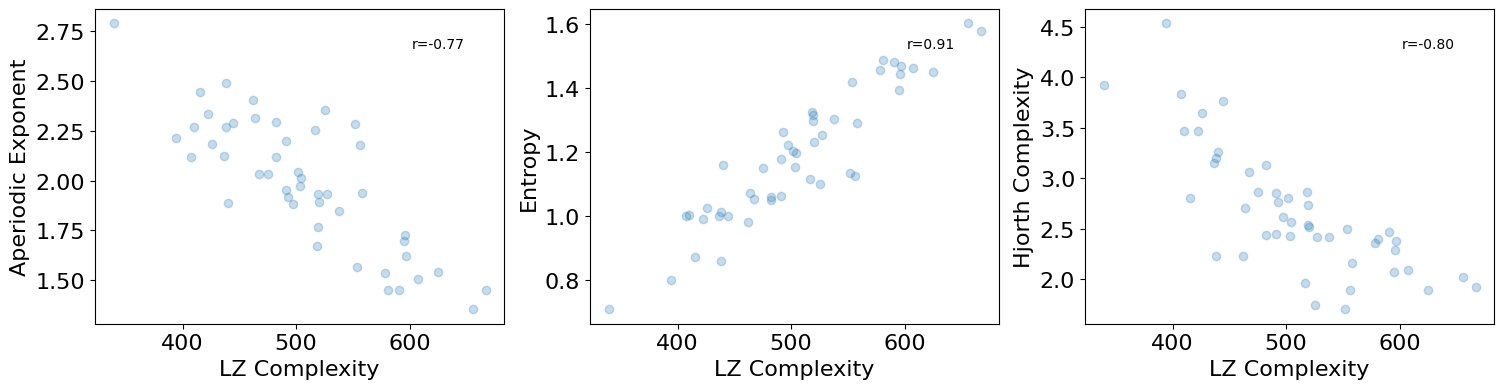

In [84]:
# Comparisons of LZ complexity to other measures
axes = make_axes(1, 3, figsize=(15, 4), wspace=0.4)
plot_dots(results['lempelziv'], results['specparam'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(results['lempelziv'], results['app_entropy'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Entropy', ax=axes[1])
plot_dots(results['lempelziv'], results['hjorth_complexity'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Hjorth Complexity', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_lzc_other' + EXT))

In [85]:
# Check correlation between Lempel Ziv complexity and other measures
print('  LZC & EXP:  ', format_corr(*all_corrs['lempelziv']['specparam']))
print('  LZC & HJC:  ', format_corr(*all_corrs['lempelziv']['hjorth_complexity']))
print('  LZC & ENT:  ', format_corr(*all_corrs['lempelziv']['app_entropy']))

  LZC & EXP:   r=-0.768  CI[-0.883, -0.577],  p=0.000
  LZC & HJC:   r=-0.795  CI[-0.903, -0.626],  p=0.000
  LZC & ENT:   r=+0.907  CI[+0.808, +0.951],  p=0.000


#### Compare Hjorth complexity to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


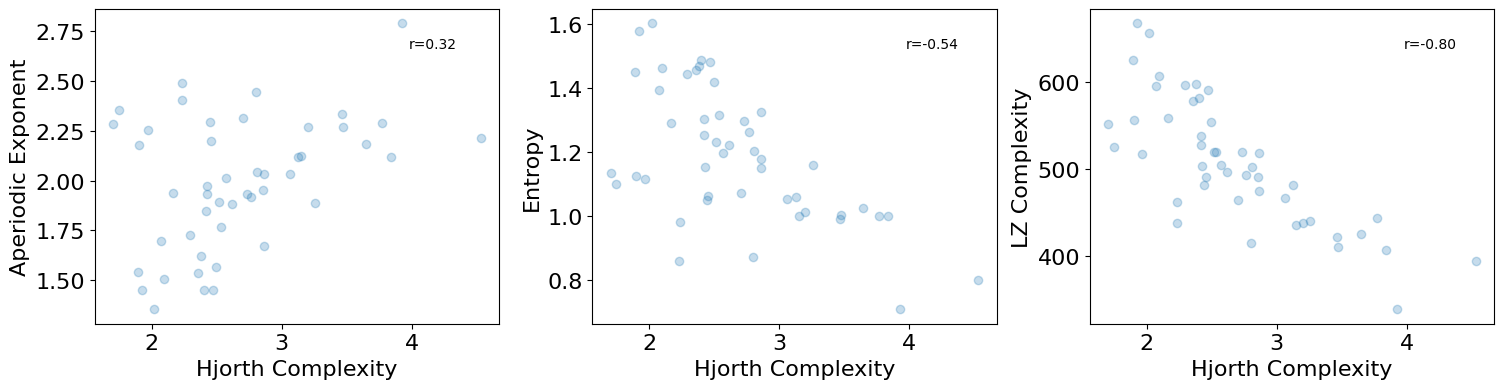

In [86]:
# Comparisons of Hjorth complexity to other measures
axes = make_axes(1, 3, figsize=(15, 4), wspace=0.4)
plot_dots(results['hjorth_complexity'], results['specparam'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(results['hjorth_complexity'], results['app_entropy'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='Entropy', ax=axes[1])
plot_dots(results['hjorth_complexity'], results['lempelziv'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='LZ Complexity', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_hjc_other' + EXT))

In [87]:
# Check correlation between Hjorth complexity and other measures
print('  HJC & EXP:  ', format_corr(*all_corrs['hjorth_complexity']['specparam']))
print('  HJC & LZC:  ', format_corr(*all_corrs['hjorth_complexity']['lempelziv']))
print('  HJC & ENT:  ', format_corr(*all_corrs['hjorth_complexity']['app_entropy']))

  HJC & EXP:   r=+0.322  CI[+0.010, +0.623],  p=0.027
  HJC & LZC:   r=-0.795  CI[-0.903, -0.626],  p=0.000
  HJC & ENT:   r=-0.538  CI[-0.754, -0.268],  p=0.000


## Plot all together

In [88]:
# axes = make_axes(3, 3, figsize=(10, 8), hspace=0.35, wspace=0.35)
# plot_dots(results['lempelziv'], results['hjorth_complexity'], alpha=0.25,
#           xlabel='LZ Complexity', ylabel='Hjorth Complexity', ax=axes[0, 0])

# plot_dots(results['specparam'], results['hjorth_complexity'], alpha=0.25,
#           xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[2, 0])
# plot_dots(results['specparam'], results['lempelziv'], alpha=0.25,
#           xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[2, 1])
# plot_dots(results['specparam'], results['app_entropy'], alpha=0.25,
#           xlabel='Aperiodic Exponent', ylabel='Entropy', ax=axes[2, 2])

# plot_dots(results['app_entropy'], results['lempelziv'], alpha=0.25,
#           xlabel='Entropy', ylabel='LZ Complexity', ax=axes[1, 1])
# plot_dots(results['app_entropy'], results['hjorth_complexity'], alpha=0.25,
#           xlabel='Entropy', ylabel='Hjorth Complexity', ax=axes[1, 0])

# for i1, i2 in [[0, 1], [0, 2], [1, 2]]:
#     axes[i1][i2].axis('off')

# #plt.subplots_adjust(hspace=0.35, wspace=0.35)
# # if SAVE_FIG: plt.savefig(FIGPATH / ('ieeg_exp_other' + EXT))

## Compare to Alpha

In [89]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

In [90]:
# Compute periodic measures
peak_results = run_measures(data, peak_measures)

In [91]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [92]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [93]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=-0.263  CI[-0.547, +0.046],  p=0.074
     hurst               :   r=+nan  CI[+nan, +nan],  p=nan
     dfa                 :   r=-0.224  CI[-0.491, +0.067],  p=0.130
     higuchi_fd          :   r=-0.184  CI[-0.460, +0.127],  p=0.216
     hjorth_complexity   :   r=-0.199  CI[-0.482, +0.114],  p=0.179
     lempelziv           :   r=+0.137  CI[-0.192, +0.441],  p=0.357
     app_entropy         :   r=+0.004  CI[-0.314, +0.324],  p=0.977
     perm_entropy        :   r=-0.118  CI[-0.382, +0.154],  p=0.429
     specparam           :   r=+0.055  CI[-0.263, +0.346],  p=0.714
     irasa               :   r=+0.165  CI[-0.129, +0.421],  p=0.266


## Conclusions

The iEEG data broadly replicates analyses on the EEG datasets. 